# Moveit IK performance testing

## set running directory to project source

In [1]:
import os
import numpy as np
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

## PlanningScene

##### initialize CombinedRobot and GeometryScene

In [2]:
from pkg.controller.combined_robot import *
from pkg.project_config import *
from pkg.geometry.builder.scene_builder import SceneBuilder

s_builder = SceneBuilder(None)   # create scene builder without detector for virtual scene
crob = CombinedRobot(robots_on_scene=[
    RobotConfig(0, RobotType.indy7gripper, ((0,0,0), (0,0,0)), None)]
                     , connection_list=[False])
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(color=(0,1,0,0.5), display=True, collision=True)
gscene.show_pose(crob.home_pose)

connection command:
indy0: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


##### create PlanningScene

In [3]:
from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

## MotionPlanner

##### MoveitPlanner
* *get_available_binding_dict()* gets available binding states for each subject in a dictionary
* *sample_leaf_state samples()* target state with given available_binding_dict and target node
* *rebind_all()* updates binding state and returns the resultant state
* The motions tested in this section are:
  - pick: move the object to "gripper"
  - place: move the object to "goal"
  - sweep: 
    1) approach to waypoint 1
    2) sweep to waypoint 2
    3) return to home pose

In [4]:
gtimer = GlobalTimer.instance()
gtimer.reset()

In [5]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene)

## Test IK

In [6]:
robot_name = "indy0"
goal_pose = (0.6,0,0.3) + tuple(Rotation.from_dcm(Rot_axis(2, np.pi)).as_quat())
timeout_single = 0.01
gtimer = GlobalTimer.instance()
gtimer.reset(stack=True)

In [21]:
Q_list = []
succ_list = []
for _ in range(100):
    with gtimer.block("solve_ik_py"):
        Q = mplan.planner.solve_ik_py(robot_name, goal_pose, timeout_single)
        succ = Q is not None
        succ_list.append(succ)
        if succ:
            Q_list.append(Q)
print("="*30)
print("success: {:.5} %".format(np.mean(succ_list)*100))
unique_solutions = sorted(set(list(map(lambda x: tuple(np.round(x, 3)), Q_list))))
print("solution count: {}".format(len(unique_solutions)))
print("="*30)
print("unique solutions")
for Q in unique_solutions:
    print("  {}".format(Q))

success: 90.0 %
solution count: 6
unique solutions
  (0.316, -1.786, 1.404, -0.0, -2.759, 0.316)
  (0.316, -0.593, -1.404, -0.0, -1.145, 0.316)
  (2.826, 0.593, 1.404, -0.0, 1.145, -3.458)
  (2.826, 0.593, 1.404, -0.0, 1.145, 2.826)
  (2.826, 1.786, -1.404, -0.0, 2.759, -3.458)
  (2.826, 1.786, -1.404, 0.0, 2.759, 2.826)


## Show one solution

In [22]:
gscene.show_pose(Q_list[0])

## Plot results

In [23]:
import matplotlib.pyplot as plt

time average(std): 4.2 (3.67) ms


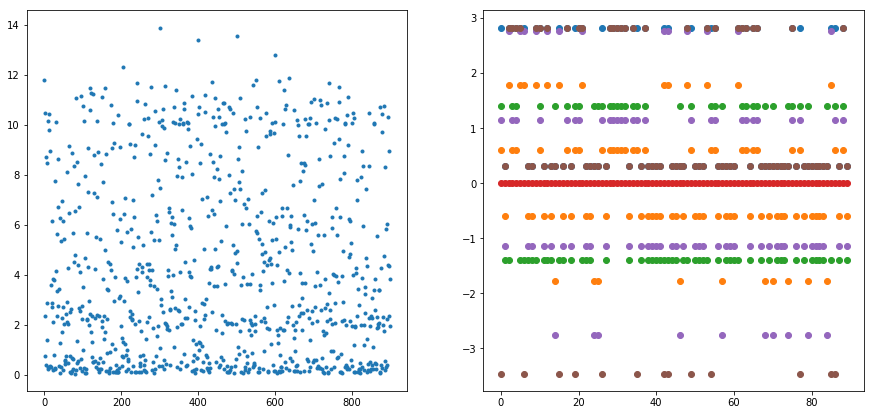

In [24]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(gtimer.timelist_dict["solve_ik_py"], '.')
plt.subplot(1,2,2)
plt.plot(Q_list, 'o')
print("time average(std): {:.3} ({:.3}) ms".format(
    np.mean(gtimer.timelist_dict["solve_ik_py"]), 
    np.std(gtimer.timelist_dict["solve_ik_py"])
))